1. Load Dataset

In [5]:
import pandas as pd

df = pd.read_csv('NFL Play by Play 2009-2018 (v5).csv')
df.head()


/tmp/ipython-input-1178744260.py:3: DtypeWarning: Columns (42,174,175,178,179,182,183,188,189,203,204,205,231,232,233,238,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NFL Play by Play 2009-2018 (v5).csv')


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0


2. Select and Clean Relevant Columns

In [6]:
# Start from the original df
cols = [
    'play_type',        # 'run', 'pass', 'punt', etc.
    'down',             # 1-4
    'ydstogo',          # Distance to first down
    'yardline_100',     # Field position (0-100)
    'qtr',              # Quarter
    'score_differential',
    'posteam',
    'defteam',
    'posteam_type',
    'game_date'
]

df_small = df[cols].copy()

# Keep only run/pass plays (lowercase in this dataset)
df_small = df_small[df_small['play_type'].isin(['run', 'pass'])]

# Drop rows with missing important values
df_small = df_small.dropna(subset=['down', 'ydstogo', 'yardline_100', 'qtr', 'score_differential'])

# Reset index
df_small = df_small.reset_index(drop=True)

print("Rows after filtering:", len(df_small))
df_small.head()


Rows after filtering: 10511


,play_type,down,ydstogo,yardline_100,qtr,score_differential,posteam,defteam,posteam_type,game_date
0,pass,1.0,10,58.0,1,0.0,PIT,TEN,home,2009-09-10
1,run,2.0,5,53.0,1,0.0,PIT,TEN,home,2009-09-10
2,pass,3.0,8,56.0,1,0.0,PIT,TEN,home,2009-09-10
3,run,1.0,10,98.0,1,0.0,TEN,PIT,away,2009-09-10
4,pass,2.0,10,98.0,1,0.0,TEN,PIT,away,2009-09-10


3. Prepare Data (Encoding & Train/Test Split)        

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

data = df_small.copy()

# Encode label: pass = 1, run = 0
data['play_type_encoded'] = (data['play_type'] == 'pass').astype(int)

# Convert game_date to year only
data['game_date'] = pd.to_datetime(data['game_date'], errors='coerce')
data['game_year'] = data['game_date'].dt.year

# Encode categorical columns
cat_cols = ['posteam', 'defteam', 'posteam_type']
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Features and label
X = data[['down', 'ydstogo', 'yardline_100', 'qtr',
          'score_differential', 'posteam', 'defteam',
          'posteam_type', 'game_year']]
y = data['play_type_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
X_train.head()


Training samples: 8408
Testing samples: 2103


,down,ydstogo,yardline_100,qtr,score_differential,posteam,defteam,posteam_type,game_year
2492,1.0,10,73.0,2,-3.0,23,19,1,2009
9051,1.0,10,48.0,2,14.0,0,12,1,2009
7866,2.0,4,85.0,3,21.0,23,29,1,2009
2534,3.0,11,78.0,3,18.0,19,23,0,2009
7395,1.0,10,69.0,4,-32.0,28,27,0,2009


4. Baseline Model: Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Create and train baseline model
baseline = LogisticRegression(max_iter=500)
baseline.fit(X_train, y_train)

# Predict
baseline_preds = baseline.predict(X_test)

# Metrics
baseline_accuracy = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds)

print("Baseline Logistic Regression Accuracy:", baseline_accuracy)
print("Baseline Logistic Regression F1 Score:", baseline_f1)
print("\nClassification Report:\n", classification_report(y_test, baseline_preds))


Baseline Logistic Regression Accuracy: 0.6286257727056586
Baseline Logistic Regression F1 Score: 0.6849536103267446

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.52      0.55       909
           1       0.66      0.71      0.68      1194

    accuracy                           0.63      2103
   macro avg       0.62      0.62      0.62      2103
weighted avg       0.63      0.63      0.63      2103



5. Main Model: Gradient Boosting Classifier

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

# Create and train main model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Predict
gb_preds = gb.predict(X_test)

# Metrics
gb_accuracy = accuracy_score(y_test, gb_preds)
gb_f1 = f1_score(y_test, gb_preds)

print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting F1 Score:", gb_f1)
print("\nClassification Report:\n", classification_report(y_test, gb_preds))


Gradient Boosting Accuracy: 0.6595339990489777
Gradient Boosting F1 Score: 0.7103559870550162

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       909
           1       0.69      0.74      0.71      1194

    accuracy                           0.66      2103
   macro avg       0.65      0.65      0.65      2103
weighted avg       0.66      0.66      0.66      2103



6. Confusion Matrix (Gradient Boosting)

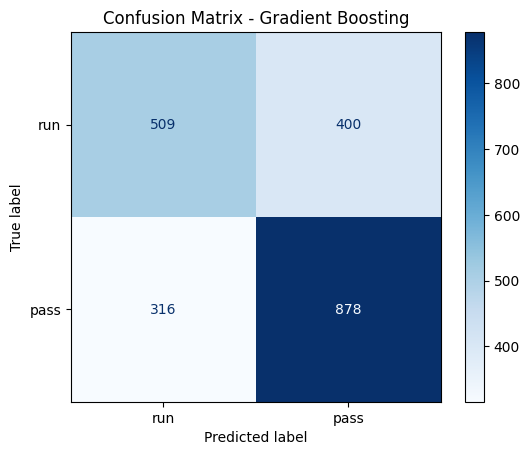

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, gb_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["run", "pass"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()



7. Model Accuracy Comparison

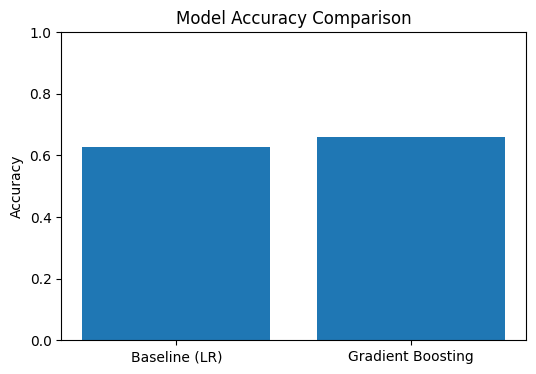

In [14]:
plt.figure(figsize=(6,4))
plt.bar(["Baseline (LR)", "Gradient Boosting"],
        [baseline_accuracy, gb_accuracy])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


8. Feature Importance Analysis

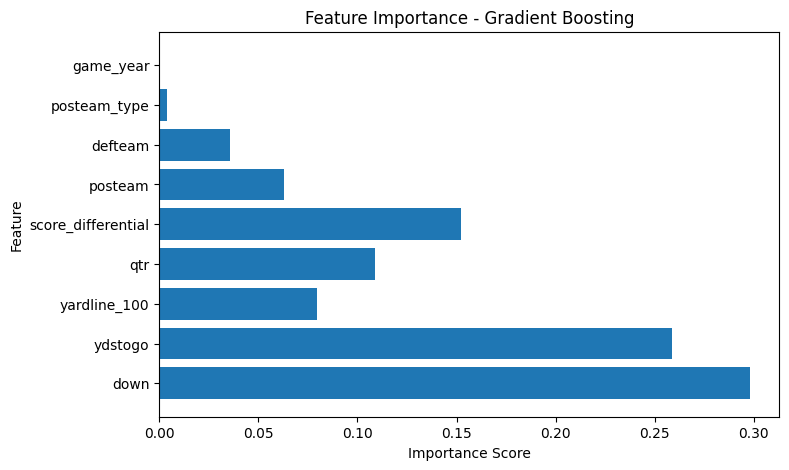

In [15]:
import numpy as np

feature_importances = gb.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,5))
plt.barh(feature_names, feature_importances)
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


9. Input Example (First 5 Plays)

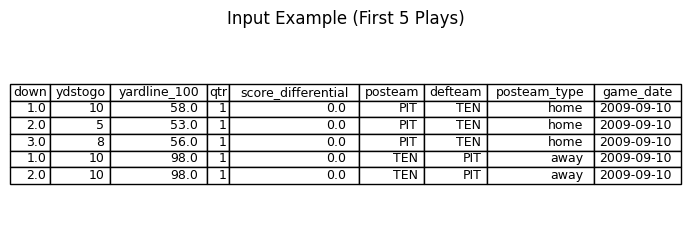

In [16]:
import matplotlib.pyplot as plt

# ----- INPUT TABLE -----
# Take first 5 rows of features (no label)
input_example = df_small.drop(columns=['play_type']).head(5)

fig, ax = plt.subplots(figsize=(7, 2.5))  # wider, short table
ax.axis('off')

table = ax.table(
    cellText=input_example.values,
    colLabels=input_example.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.auto_set_column_width(col=list(range(len(input_example.columns))))

plt.title("Input Example (First 5 Plays)", pad=10)
plt.tight_layout()
plt.savefig("input_example_clean.png", dpi=300)
plt.show()


10. Output Example (Labels)

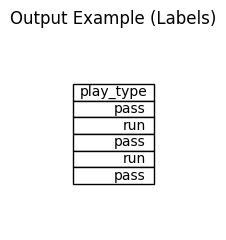

In [17]:
# ----- OUTPUT TABLE -----
output_example = df_small[['play_type']].head(5)

fig, ax = plt.subplots(figsize=(2, 2.5))
ax.axis('off')

table = ax.table(
    cellText=output_example.values,
    colLabels=output_example.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=[0])

plt.title("Output Example (Labels)", pad=10)
plt.tight_layout()
plt.savefig("output_example_clean.png", dpi=300)
plt.show()
